##### IMPORTS

In [1]:
import os
from collections import Counter
import numpy as np
from importlib import reload
import pandas as pd
import matplotlib.pyplot as plt
import functions as F

## Classifying spam emails using Naive Bayes and TF/IDF
Using bayesian updating and by vectorizing words we can classify whether or not an email that comes through is spam or not.  How does this work?  I'll explain the process a little it below, and then go throught the implimentation.

#### 1. Turning the documents into vectors
##### 1.1 Matrix with one column, and each row is a complete doc
The first step to this process is taking all of the documents (emails) that you are trying to predict whether or not are spam and put them into a single matrix.  This matrix would look like

|**Document Body**|
|:--:|
|'This would be document one including all of the text'|
|'This is document 2'|
|'This is document 3... getting the idea?'|
|'This matrix for the emails contains 702 emails for my test set'|
|'I made a matrix for just the body text of each email'|
|'I also made a matrix for just the subject of each email'|


##### 1.2 Matrix with same number of rows, but a col that represents each unique word

Now we are going to transform our matrix from one that only has a single col to a matrix that contains a col for every unique word.  What if the word is contained twice in our document?  Well, we put the number of counts in that document into this matrix:

|**Doc Name**| word1|word2|...|word n-1|word n|
|:----------:|:----:|:---:|:-:|:------:|:----:|
|**doc1**|1|1|...|0|1|
|**doc2**|2|0|...|1|1|
|**doc1**|2|2|...|1|1|

The structure of this matrix is crucial.  Play with it in your mind for a while, the longer the better.  This is what allows us to map our results back to specific words which gives us a better understanding of what is actually going on.  

##### 1.3 Normalizing the word counts
This is where things get a little difficult, but for an intuitive understand, try this out.  If we have to vectors pointing in the same direction, but one has a much greater magnitude, our model will not see them as similar.  To account for this, we need to normalize our matrix.  Sklearn has an implimintation of this using a method TFIDF.  This also has some interesting features that can process the words for you, and get rid of nonsensical words.  Along with other cool features, this is a great way to vectorize your data.  I will leave it up to the user to explore the available options with the sklearn package.

### 2. Creating a pipeline that takes in emails and predicts the probability of the email being spam

Start by creating a function that is called **extract_features.**  This function takes in the directory that all of the emails are in.  We take the emails, and read the body of the email.  Then add the body of each document to a list of documents so that I have all the text saved as a new line.  

The structure of this matrix is 1 col, and each row is just the document.  I did this for both the subjects and the bodies of each of the emails.

Once I have this corpus _(collection of all of my documents as a list)_ I can vectorize it using the sklearn implimentation.  Doing this by creating **two** different vectorizers.  One for the subject and one for the body of the email. 

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer 
reload(F)
train_dir = 'ling-spam/train-mails'
test_dir = 'ling-spam/test-mails'

#Create vectorizor
Body_vectorizor = TfidfVectorizer(analyzer='word', ngram_range=(1,5), min_df = 0, stop_words = 'english')
Subject_vectorizor = TfidfVectorizer(analyzer='word', ngram_range=(1,5), min_df = 0, stop_words = 'english')

#extract a corpus for the bodys, subjects, and targets
docs,subjects, target = F.extract_features(train_dir)

#transform into matrix format
body_matrix = Body_vectorizor.fit_transform(docs)
subject_matrix = Subject_vectorizor.fit_transform(subjects)
print(':'*50)
print('\nThe size of the subject line vectors is: ',subject_matrix.shape)
print('-'*50)
print('The size of the body vectors is: ',body_matrix.shape)
print('-'*50)
print('The size of the target vector is: ',len(target),'\n')
print(':'*50)

::::::::::::::::::::::::::::::::::::::::::::::::::

The size of the subject line vectors is:  (702, 5385)
--------------------------------------------------
The size of the body vectors is:  (702, 509782)
--------------------------------------------------
The size of the target vector is:  702 

::::::::::::::::::::::::::::::::::::::::::::::::::


### Modeling Part 1:
Since I created two different vectorized systems of the words, I will need to do one of two things to train models
1. Train a model on the seperate vector systems
2. Concatinate the vector systems and then create a model

I am going to first train a model on the seperate vector systems to see the feature importance.  This will be cool because we will get to see what is driving the classification of spam for both of the models.  After this, I will impliment a system that puts both of these vectors together and then predicts off of the concatinated matricies.  

It is much harder to map back to the origin words after I have put the matricies together so that is why I am going through this process first.

In [3]:
from sklearn.ensemble import GradientBoostingClassifier as GB

#Initialize and train a model for the body of the email
body_model = GB(n_estimators = 10, learning_rate = .5)
body_model.fit(body_matrix,target);

#Initialize and train a model for the subject line of the email
subject_model = GB(n_estimators = 10, learning_rate = .5)
subject_model.fit(subject_matrix,target);

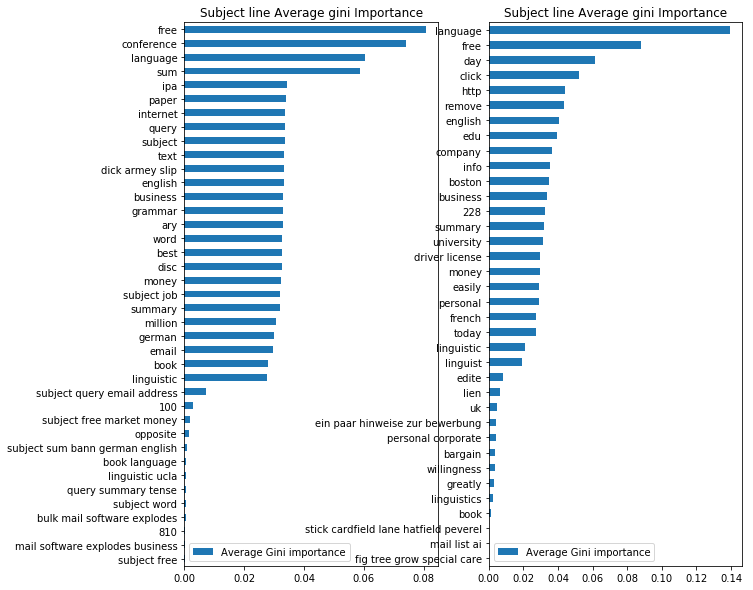

In [4]:
_,ax = plt.subplots(1,2,figsize = (10,10))
reload(F)
F.plot_feat_importance(ax[0],subject_model,Subject_vectorizor)
F.plot_feat_importance(ax[1],body_model,Body_vectorizor);

### Fitting the model for the concatenated matricies
The first thing I need to do is to concatinate the two matricies I have created into a single matrix that contains both but has a higher weight for the subject lines. 

This contains the matrix for both the subject lines and the body elements of each email.

Here I am weighting the subject line 3x more heavily than the body words, Cool

Below is the code to do that:

In [5]:
from scipy.sparse import hstack
from scipy import sparse

#concat
sub_and_body = np.concatenate((body_matrix.todense(),3*subject_matrix.todense()),axis = 1)

#convert back to sparse
sub_and_body = sparse.csr_matrix(sub_and_body)

#print the resulting matrix size
print('-'*50)
print('The resulting size after concatenation is: ',
      sub_and_body.shape)
print('-'*50)

--------------------------------------------------
The resulting size after concatenation is:  (702, 515167)
--------------------------------------------------


### Training the Final Model:
Now that we concatenated the matricies together, we can predict off of the new dataset.  We need to first fit our model, then load the testing dataset and apply the same vectorization to it.  Once we get this done we can predict off the test dataset.

For this I am going to use the **GradientBoostingClassifier** from Sklearn.  This is a great classifier and fairly robust.  More information can be found from sklean documentation on this specific classifier.

In [6]:
from sklearn.ensemble import GradientBoostingClassifier as GB
import pandas as pd

#Train the final model
total_model = GB(n_estimators = 200, learning_rate = .01)
total_model.fit(sub_and_body,target);

In [7]:
print('Total clasfication percent correct: ',
      sum(target == total_model.predict(sub_and_body))/len(target)*100,
      '%')

Total clasfication percent correct:  98.14814814814815 %


Wow! Thats really great prediction on the training data.  Lets move on and apply this to the test dataset which was already split out:

### Load in the testing dataset, vectorize, and then concatinate
**Make sure to apply the same weight as before to the subject line matrix**

In [8]:
#extract a corpus for the bodys, subjects, and targets
docs,subjects, target = F.extract_features(test_dir)

#transform into matrix format
body_matrix = Body_vectorizor.transform(docs)
subject_matrix = Subject_vectorizor.transform(subjects)

sub_and_body = np.concatenate((body_matrix.todense(),3*subject_matrix.todense()),axis = 1)


In [9]:
print('Total clasfication percent correct: ',
      sum(target == total_model.predict(sub_and_body))/len(target)*100,
      '%')

Total clasfication percent correct:  91.15384615384615 %


Wow we are getting really great results.  

I was very careful to ensure that there was no data-leakage, and I am excited to impliment this system as my personal spam detection software.

This is really cool though.  Using this method I was able to classify whether or not something was spam to over 90% accuracy. 

If I where to use this on my own personal email list, I could classify specific senders as spam along with the application of predicting based on the subject line and text body.  I would need to optimize this to do a better job by using ROC curves and using information about the number of false postitives and true negatives.  Since I have such great accuracy, I could ensure that there are virtually zero false positives and using this make sure that I never miss an important email.  Rad!

### Next steps
- Look at the number of true positives and false positive
- plot roc curve
- Decide where a good cutoff is for my spam filter